# Notebook 02: Scenario-Based & Risk-Aware Dispatch (CVaR)
This notebook builds **K=20** historical daily price scenarios and compares:
- Deterministic plan (mean forecast)
- Expected-value plan (equivalent here)
- **CVaR risk-aware** plans (λ ∈ {0.1, 1.0, 2.0})

We quantify the tradeoff between expected revenue and downside protection, and plot an **efficient frontier**.


## 0. Setup

In [ ]:
# !pip -q install pyomo highspy pandas numpy matplotlib

import sys
from pathlib import Path

repo_root = Path('..').resolve()
sys.path.append(str(repo_root / 'src'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import load_pjm_prices_csv
from models import build_price_scenarios, solve_deterministic_dispatch, solve_expected_value_dispatch, solve_cvar_dispatch
from evaluation import summarize_plan, efficient_frontier_from_summary

## 1. Load prices and build scenarios

In [ ]:
data_path = repo_root / "data" / "raw" / "pjm_rt_hourly_western_hub_2025Q1.csv"
df = load_pjm_prices_csv(str(data_path))

K = 20
HORIZON = 24
scenarios, scenario_days = build_price_scenarios(df, horizon=HORIZON, K=K, seed=42)

print("scenarios shape:", scenarios.shape)
print("sampled days:", scenario_days[:5])

C:\Users\melsh\Documents\my_workspace\energy-storage-dispatch-risk-aware-optimization\src\data_utils.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out["timestamp"] = pd.to_datetime(out["timestamp"])


scenarios shape: (20, 24)
sampled days: [datetime.date(2025, 2, 24), datetime.date(2025, 3, 25), datetime.date(2025, 1, 16), datetime.date(2025, 3, 21), datetime.date(2025, 3, 16)]


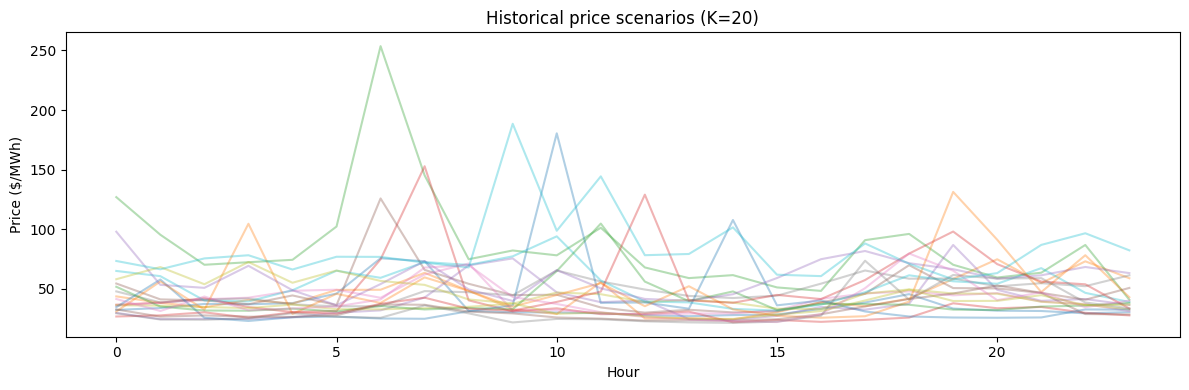

In [3]:
# Visualize scenario price paths
plt.figure(figsize=(12,4))
for s in range(K):
    plt.plot(scenarios[s], alpha=0.35)
plt.title("Historical price scenarios (K=20)")
plt.xlabel("Hour")
plt.ylabel("Price ($/MWh)")
plt.tight_layout()
plt.show()

## 2. Solve baseline plans
For this linear objective with a single here-and-now plan, **expected-value optimization** is equivalent to optimizing against the **mean price forecast**.


In [4]:
mean_price = scenarios.mean(axis=0)

det_plan = solve_deterministic_dispatch(mean_price)
ev_plan = solve_expected_value_dispatch(scenarios)  # same as deterministic(mean_price)

## 3. Solve CVaR risk-aware plans

In [5]:
alpha = 0.10  # tail fraction
cvar_plan_01, stats_01 = solve_cvar_dispatch(scenarios, alpha=alpha, lam=0.1)
cvar_plan_10, stats_10 = solve_cvar_dispatch(scenarios, alpha=alpha, lam=1.0)
cvar_plan_20, stats_20 = solve_cvar_dispatch(scenarios, alpha=alpha, lam=2.0)

stats_01, stats_10, stats_20

({'expected_revenue': 4279.363965371859,
  'cvar_loss': -650.3787432597439,
  'zeta': -650.3787432597439,
  'alpha': 0.1,
  'lambda': 0.1},
 {'expected_revenue': 4205.653382678592,
  'cvar_loss': -968.765872238494,
  'zeta': -1021.205842438301,
  'alpha': 0.1,
  'lambda': 1.0},
 {'expected_revenue': 4187.80039424529,
  'cvar_loss': -982.0359373585609,
  'zeta': -1028.7516479732426,
  'alpha': 0.1,
  'lambda': 2.0})

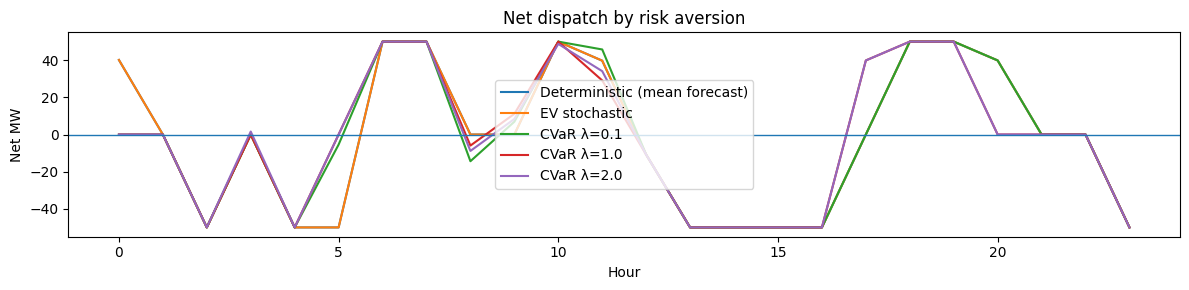

In [6]:
# Net dispatch comparison
def net(plan):
    return plan["discharge"] - plan["charge"]

plt.figure(figsize=(12,3))
plt.plot(net(det_plan), label="Deterministic (mean forecast)")
plt.plot(net(ev_plan), label="EV stochastic")
plt.plot(net(cvar_plan_01), label="CVaR λ=0.1")
plt.plot(net(cvar_plan_10), label="CVaR λ=1.0")
plt.plot(net(cvar_plan_20), label="CVaR λ=2.0")
plt.axhline(0, linewidth=1)
plt.legend()
plt.title("Net dispatch by risk aversion")
plt.xlabel("Hour")
plt.ylabel("Net MW")
plt.tight_layout()
plt.show()

## 4. Evaluate performance across scenarios

In [7]:
summary = pd.DataFrame([
    summarize_plan(det_plan, scenarios, "deterministic_mean"),
    summarize_plan(ev_plan, scenarios, "stochastic_EV"),
    summarize_plan(cvar_plan_01, scenarios, "cvar_lam_0.1"),
    summarize_plan(cvar_plan_10, scenarios, "cvar_lam_1.0"),
    summarize_plan(cvar_plan_20, scenarios, "cvar_lam_2.0"),
])

summary

,plan,mean_revenue,p10_revenue,worst_revenue,std_revenue
0,deterministic_mean,4352.503574,489.383042,-1029.034675,4251.064047
1,stochastic_EV,4352.503574,489.383042,-1029.034675,4251.064047
2,cvar_lam_0.1,4279.363965,650.378743,650.378743,4118.608154
3,cvar_lam_1.0,4205.653383,1021.205842,916.325902,4175.097873
4,cvar_lam_2.0,4187.800394,1028.751648,935.320227,4170.769288


## 5. Efficient frontier (Expected value vs downside risk)

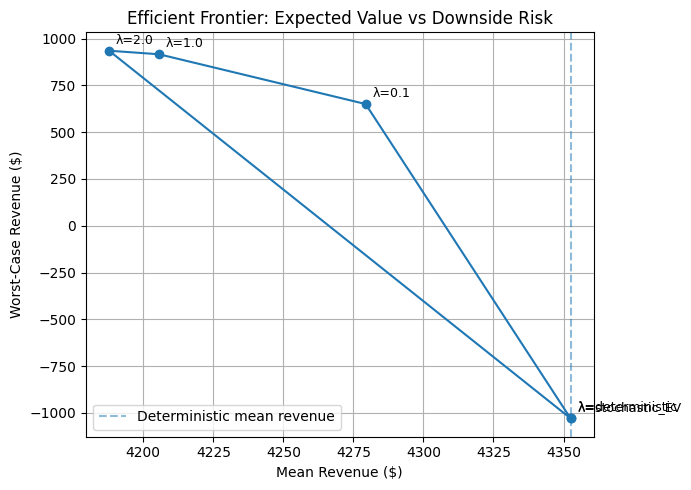

In [8]:
frontier = efficient_frontier_from_summary(summary)

# Sort in a sensible order for plotting
order = {"deterministic": 0, "0.1": 1, "1.0": 2, "2.0": 3}
frontier["order"] = frontier["lambda"].astype(str).map(order).fillna(99)
frontier = frontier.sort_values("order")

plt.figure(figsize=(7,5))
plt.plot(frontier["mean_revenue"], frontier["worst_revenue"], marker="o")

for _, row in frontier.iterrows():
    plt.annotate(f"λ={row['lambda']}",
                 (row["mean_revenue"], row["worst_revenue"]),
                 textcoords="offset points", xytext=(5,5), fontsize=9)

det_mean = float(frontier.loc[frontier["lambda"]=="deterministic", "mean_revenue"].values[0])
plt.axvline(det_mean, linestyle="--", alpha=0.5, label="Deterministic mean revenue")

plt.xlabel("Mean Revenue ($)")
plt.ylabel("Worst-Case Revenue ($)")
plt.title("Efficient Frontier: Expected Value vs Downside Risk")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Findings (risk-aware optimization)
> Adding CVaR risk aversion produces a tunable tradeoff between expected arbitrage value and downside protection. Even modest risk aversion substantially improves worst-case outcomes, while larger λ values exhibit diminishing returns. This mirrors how operators choose an explicit risk posture rather than implicitly accepting tail risk.
